In [ ]:
!pip install gensim
!pip install arabicstopwords
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ERROR: Could not find a version that s

In [ ]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
!gunzip cc.ar.300.vec.gz

--2025-05-10 04:56:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G   168MB/s    in 8.6s    

2025-05-10 04:56:11 (141 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [ ]:
!pip install gensim
!pip install --force-reinstall numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 29.3 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:


In [ ]:
!pip install --force-reinstall numpy
!pip install --force-reinstall gensim

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using 

In [ ]:
!pip install --force-reinstall pandas==2.0.3
!pip install --force-reinstall numpy==1.25.2

  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 56.7 MB/s eta 0:00:00
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installatio

  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.2 requires pandas>=0.24.2, which is not installed.
arviz 0.21.0 requires pandas>=1.5.0, which is not installed.
shap 0.47.2 requires pandas, which is not installed.
dask-cuda 25.2.0 requires pandas>=1.3, which is not installed.
statsmodels 0.14.4 requires pandas!=2.1.0,>=1.4, which is not installed.
bqplot 0.12.44 requires pandas<3.0.0,>=1.0.0, which is not installed.
xarray 2025.3.1 requires pandas>=2.1, which is not installed.
mlxtend 0.23.4 requires pandas

In [ ]:
!pip uninstall pandas numpy -y

Found existing installation: pandas 2.0.3
Uninstalling pandas-2.0.3:
  Successfully uninstalled pandas-2.0.3
Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Successfully uninstalled numpy-2.2.5


In [ ]:
!pip install pandas==2.0.3 numpy==1.25.2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

class ArabicSentimentClassifier:
    def __init__(self, max_len=100, embedding_dim=300):
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.model = None
        self.embedding_matrix = None

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['Toxicity'] = pd.to_numeric(df['Toxicity'], errors='coerce')
        df.dropna(subset=['Toxicity'], inplace=True)
        self.texts = df['Comment'].astype(str).values
        self.labels = df['Toxicity'].values
        return self.texts, self.labels

    def preprocess(self):
        # Tokenize and pad
        self.tokenizer.fit_on_texts(self.texts)
        sequences = self.tokenizer.texts_to_sequences(self.texts)
        self.word_index = self.tokenizer.word_index
        padded = pad_sequences(sequences, maxlen=self.max_len)
        return padded

    def load_fasttext(self, fasttext_path):
        print("Loading FastText embeddings...")
        embeddings_index = {}
        with open(fasttext_path, encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        num_words = len(self.word_index) + 1
        self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector

        return num_words

    def build_model(self, num_words, trainable=True):
        input_layer = Input(shape=(self.max_len,))
        embedding_layer = Embedding(
            input_dim=num_words,
            output_dim=self.embedding_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_len,
            trainable=trainable
        )(input_layer)

        x = Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3))(embedding_layer)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(self.model.summary())

    def train(self, X, y, val_split=0.1, batch_size=128, epochs=15):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        )
        class_weights_dict = dict(enumerate(class_weights))

        history = self.model.fit(
            X, y,
            validation_split=val_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stop],
            class_weight=class_weights_dict
        )

        self.plot_history(history)

    def cross_validate(self, X, y, folds=5, batch_size=64, epochs=10):
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=20)
        reports = []

        fold_no = 1
        for train_idx, val_idx in skf.split(X, y):
            print(f"\nFold {fold_no}/{folds}")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Rebuild model for each fold
            self.build_model(num_words=len(self.word_index) + 1, trainable=True)

            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(enumerate(class_weights))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=class_weights_dict,
                verbose=0
            )

            # Predict and report
            y_pred = (self.model.predict(X_val) > 0.5).astype("int32")
            report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
            reports.append(report)

            print(classification_report(y_val, y_pred, zero_division=0))
            fold_no += 1

        return reports

    def plot_history(self, history):
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.grid()
        plt.title('Training History')
        plt.show()


classifier = ArabicSentimentClassifier(max_len=100, embedding_dim=300)
texts, labels = classifier.load_data('H_Comments.csv')
X = classifier.preprocess()
y = np.array(labels)
num_words = classifier.load_fasttext('/content/cc.ar.300.vec')
reports = classifier.cross_validate(X, y, folds=5, batch_size=128, epochs=15)
f1_scores = [r['1.0']['f1-score'] if '1.0' in r else 0 for r in reports]

print(f"\nMean F1-score (toxic): {np.mean(f1_scores):.4f}")

Loading FastText embeddings...


KeyboardInterrupt: 

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

class ArabicSentimentClassifier:
    def __init__(self, max_len=100, embedding_dim=300):
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.model = None
        self.embedding_matrix = None

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['Type'] = pd.to_numeric(df['Type'], errors='coerce')
        df.dropna(subset=['Type'], inplace=True)
        self.texts = df['Comment'].astype(str).values
        self.labels = df['Type'].values
        return self.texts, self.labels

    def preprocess(self):
        # Tokenize and pad
        self.tokenizer.fit_on_texts(self.texts)
        sequences = self.tokenizer.texts_to_sequences(self.texts)
        self.word_index = self.tokenizer.word_index
        padded = pad_sequences(sequences, maxlen=self.max_len)
        return padded

    def load_fasttext(self, fasttext_path):
        print("Loading FastText embeddings...")
        embeddings_index = {}
        with open(fasttext_path, encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        num_words = len(self.word_index) + 1
        self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector

        return num_words

    def build_model(self, num_words, trainable=True):
        input_layer = Input(shape=(self.max_len,))
        embedding_layer = Embedding(
            input_dim=num_words,
            output_dim=self.embedding_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_len,
            trainable=trainable
        )(input_layer)

        x = Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3))(embedding_layer)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)  # Changed here

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Changed here
        print(self.model.summary())


    def train(self, X, y, val_split=0.1, batch_size=128, epochs=15):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        )
        class_weights_dict = dict(enumerate(class_weights))

        history = self.model.fit(
            X, y,
            validation_split=val_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stop],
            class_weight=class_weights_dict
        )

        self.plot_history(history)

    def cross_validate(self, X, y, folds=5, batch_size=128, epochs=10):
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=20)
        reports = []

        fold_no = 1
        for train_idx, val_idx in skf.split(X, y):
            print(f"\nFold {fold_no}/{folds}")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Rebuild model for each fold
            self.build_model(num_words=len(self.word_index) + 1, trainable=True)

            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(enumerate(class_weights))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=class_weights_dict,
                verbose=0
            )

            # Predict and report
            y_pred_probs = self.model.predict(X_val) # get predicted probabilities
            y_pred = np.argmax(y_pred_probs, axis=1) # convert probabilities to class labels
            report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
            reports.append(report)

            print(classification_report(y_val, y_pred, zero_division=0))
            fold_no += 1

        return reports


classifier = ArabicSentimentClassifier(max_len=100, embedding_dim=300)
texts, labels = classifier.load_data('Y_Comments.csv')
X = classifier.preprocess()
y = np.array(labels)
num_words = classifier.load_fasttext('/content/cc.ar.300.vec')
reports = classifier.cross_validate(X, y, folds=5, batch_size=128, epochs=15)
f1_scores = [r['1.0']['f1-score'] if '1.0' in r else 0 for r in reports]
y_pred = classifier.model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(f"\nMaximum F1-score (toxic): {np.max(f1_scores):.4f}")
print(f"\nMaximum Accuracy (toxic): {np.max(f1_scores):.4f}")
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Loading FastText embeddings...

Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 300)       │    12,040,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,480,267 (47.61 MB)

 Trainable params: 12,480,267 (47.61 MB)

 Non-trainable params: 0 (0.00 B)

None
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.70       694
         1.0       0.68      0.63      0.65       903
         2.0       0.70      0.71      0.70       644

    accuracy                           0.68      2241
   macro avg       0.68      0.69      0.68      2241
weighted avg       0.68      0.68      0.68      2241


Fold 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 300)       │    12,040,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,480,267 (47.61 MB)

 Trainable params: 12,480,267 (47.61 MB)

 Non-trainable params: 0 (0.00 B)

None
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step
              precision    recall  f1-score   support

         0.0       0.65      0.70      0.68       694
         1.0       0.71      0.59      0.64       903
         2.0       0.65      0.77      0.71       644

    accuracy                           0.67      2241
   macro avg       0.67      0.68      0.67      2241
weighted avg       0.68      0.67      0.67      2241


Fold 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 100, 300)       │    12,040,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,480,267 (47.61 MB)

 Trainable params: 12,480,267 (47.61 MB)

 Non-trainable params: 0 (0.00 B)

None
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step
              precision    recall  f1-score   support

         0.0       0.64      0.70      0.67       694
         1.0       0.67      0.60      0.63       903
         2.0       0.72      0.75      0.74       644

    accuracy                           0.67      2241
   macro avg       0.68      0.68      0.68      2241
weighted avg       0.67      0.67      0.67      2241


Fold 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 100, 300)       │    12,040,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,480,267 (47.61 MB)

 Trainable params: 12,480,267 (47.61 MB)

 Non-trainable params: 0 (0.00 B)

None
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step
              precision    recall  f1-score   support

         0.0       0.60      0.81      0.69       695
         1.0       0.73      0.49      0.59       902
         2.0       0.70      0.75      0.72       644

    accuracy                           0.66      2241
   macro avg       0.68      0.68      0.67      2241
weighted avg       0.68      0.66      0.66      2241


Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 100, 300)       │    12,040,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,480,267 (47.61 MB)

 Trainable params: 12,480,267 (47.61 MB)

 Non-trainable params: 0 (0.00 B)

None
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.81      0.67       695
         1.0       0.71      0.48      0.57       902
         2.0       0.71      0.69      0.70       644

    accuracy                           0.65      2241
   macro avg       0.66      0.66      0.65      2241
weighted avg       0.66      0.65      0.64      2241



NameError: name 'X_val' is not defined

In [8]:
class ArabicSentimentClassifier:
    def __init__(self, max_len=100, embedding_dim=300):
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.model = None
        self.embedding_matrix = None

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['Target'] = pd.to_numeric(df['Target'], errors='coerce')
        df.dropna(subset=['Target'], inplace=True)
        self.texts = df['Comment'].astype(str).values
        self.labels = df['Target'].values
        return self.texts, self.labels

    def preprocess(self):
        # Tokenize and pad
        self.tokenizer.fit_on_texts(self.texts)
        sequences = self.tokenizer.texts_to_sequences(self.texts)
        self.word_index = self.tokenizer.word_index
        padded = pad_sequences(sequences, maxlen=self.max_len)
        return padded

    def load_fasttext(self, fasttext_path):
        print("Loading FastText embeddings...")
        embeddings_index = {}
        with open(fasttext_path, encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        num_words = len(self.word_index) + 1
        self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector

        return num_words

    def build_model(self, num_words, trainable=True):
        input_layer = Input(shape=(self.max_len,))
        embedding_layer = Embedding(
            input_dim=num_words,
            output_dim=self.embedding_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_len,
            trainable=trainable
        )(input_layer)

        x = Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3))(embedding_layer)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(self.model.summary())


    def train(self, X, y, val_split=0.1, batch_size=128, epochs=15):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        )
        class_weights_dict = dict(enumerate(class_weights))

        history = self.model.fit(
            X, y,
            validation_split=val_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stop],
            class_weight=class_weights_dict
        )

        self.plot_history(history)

    def cross_validate(self, X, y, folds=3, batch_size=128, epochs=10):
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        reports = []

        fold_no = 1
        for train_idx, val_idx in skf.split(X, y):
            print(f"\nFold {fold_no}/{folds}")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Rebuild model for each fold
            self.build_model(num_words=len(self.word_index) + 1, trainable=True)

            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(enumerate(class_weights))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=class_weights_dict,
                verbose=0
            )

            # Predict and report
            y_pred_probs = self.model.predict(X_val) # get predicted probabilities
            y_pred = np.argmax(y_pred_probs, axis=1) # convert probabilities to class labels
            report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
            reports.append(report)

            print(classification_report(y_val, y_pred, zero_division=0))
            fold_no += 1

        return reports


classifier = ArabicSentimentClassifier(max_len=100, embedding_dim=300)
texts, labels = classifier.load_data('Y_Comments.csv')
X = classifier.preprocess()
y = np.array(labels)
num_words = classifier.load_fasttext('/content/cc.ar.300.vec')
reports = classifier.cross_validate(X, y, folds=3, batch_size=128, epochs=15)
f1_scores = [r['1.0']['f1-score'] if '1.0' in r else 0 for r in reports]
y_pred = classifier.model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(f"\nMaximum F1-score (toxic): {np.max(f1_scores):.4f}")
print(f"\nMaximum Accuracy (toxic): {np.max(accuracy_score):.4f}")
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Loading FastText embeddings...

Fold 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, 100, 300)       │     6,197,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,637,167 (25.32 MB)

 Trainable params: 6,637,167 (25.32 MB)

 Non-trainable params: 0 (0.00 B)

None
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00     874.0
         2.0       0.00      0.00      0.00      42.0
         3.0       0.00      0.00      0.00     357.0
         4.0       0.00      0.00      0.00      15.0

    accuracy                           0.00    1288.0
   macro avg       0.00      0.00      0.00    1288.0
weighted avg       0.00      0.00      0.00    1288.0


Fold 2/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_12 (Embedding)        │ (None, 100, 300)       │     6,197,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,637,167 (25.32 MB)

 Trainable params: 6,637,167 (25.32 MB)

 Non-trainable params: 0 (0.00 B)

None


KeyboardInterrupt: 

In [9]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat May 10 06:36:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P0             28W /   70W |    2164MiB /  15360MiB |      0%      Default |
|                                         |                        |            

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

class ArabicSentimentClassifier:
    def __init__(self, max_len=100, embedding_dim=300):
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.model = None
        self.embedding_matrix = None

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['Toxicity'] = pd.to_numeric(df['Toxicity'], errors='coerce')
        df.dropna(subset=['Toxicity'], inplace=True)
        self.texts = df['Comment'].astype(str).values
        self.labels = df['Toxicity'].values
        return self.texts, self.labels

    def preprocess(self):
        # Tokenize and pad
        self.tokenizer.fit_on_texts(self.texts)
        sequences = self.tokenizer.texts_to_sequences(self.texts)
        self.word_index = self.tokenizer.word_index
        padded = pad_sequences(sequences, maxlen=self.max_len)
        return padded

    def load_fasttext(self, fasttext_path):
        print("Loading FastText embeddings...")
        embeddings_index = {}
        with open(fasttext_path, encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        num_words = len(self.word_index) + 1
        self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector

        return num_words

    def build_model(self, num_words, trainable=True):
        input_layer = Input(shape=(self.max_len,))
        embedding_layer = Embedding(
            input_dim=num_words,
            output_dim=self.embedding_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_len,
            trainable=trainable
        )(input_layer)

        x = Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3))(embedding_layer)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(self.model.summary())

    def train(self, X, y, val_split=0.1, batch_size=128, epochs=15):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        )
        class_weights_dict = dict(enumerate(class_weights))

        history = self.model.fit(
            X, y,
            validation_split=val_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stop],
            class_weight=class_weights_dict
        )

        self.plot_history(history)

    def cross_validate(self, X, y, folds=5, batch_size=64, epochs=10):
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=20)
        reports = []

        fold_no = 1
        for train_idx, val_idx in skf.split(X, y):
            print(f"\nFold {fold_no}/{folds}")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Rebuild model for each fold
            self.build_model(num_words=len(self.word_index) + 1, trainable=True)

            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(enumerate(class_weights))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=class_weights_dict,
                verbose=0
            )

            # Predict and report
            y_pred = (self.model.predict(X_val) > 0.5).astype("int32")
            report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
            reports.append(report)

            print(classification_report(y_val, y_pred, zero_division=0))
            fold_no += 1

        return reports

    def plot_history(self, history):
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.grid()
        plt.title('Training History')
        plt.show()


classifier = ArabicSentimentClassifier(max_len=100, embedding_dim=300)
texts, labels = classifier.load_data('Y_cleaned_dataset.csv')
X = classifier.preprocess()
y = np.array(labels)
num_words = classifier.load_fasttext('/content/cc.ar.300.vec')
reports = classifier.cross_validate(X, y, folds=5, batch_size=128, epochs=15)
f1_scores = [r['1.0']['f1-score'] if '1.0' in r else 0 for r in reports]

print(f"\nMean F1-score (toxic): {np.mean(f1_scores):.4f}")

Loading FastText embeddings...

Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 100, 300)       │     3,483,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922,553 (14.96 MB)

 Trainable params: 3,922,553 (14.96 MB)

 Non-trainable params: 0 (0.00 B)

None
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       336
           1       0.75      0.60      0.67       364

    accuracy                           0.69       700
   macro avg       0.70      0.69      0.69       700
weighted avg       0.70      0.69      0.69       700


Fold 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ (None, 100, 300)       │     3,483,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922,553 (14.96 MB)

 Trainable params: 3,922,553 (14.96 MB)

 Non-trainable params: 0 (0.00 B)

None
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       336
           1       0.75      0.70      0.73       364

    accuracy                           0.72       700
   macro avg       0.73      0.73      0.72       700
weighted avg       0.73      0.72      0.72       700


Fold 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_15 (Embedding)        │ (None, 100, 300)       │     3,483,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922,553 (14.96 MB)

 Trainable params: 3,922,553 (14.96 MB)

 Non-trainable params: 0 (0.00 B)

None
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       336
           1       0.75      0.67      0.71       364

    accuracy                           0.71       700
   macro avg       0.72      0.72      0.71       700
weighted avg       0.72      0.71      0.71       700


Fold 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_16 (Embedding)        │ (None, 100, 300)       │     3,483,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922,553 (14.96 MB)

 Trainable params: 3,922,553 (14.96 MB)

 Non-trainable params: 0 (0.00 B)

None
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       336
           1       0.68      0.74      0.71       364

    accuracy                           0.68       700
   macro avg       0.68      0.68      0.68       700
weighted avg       0.68      0.68      0.68       700


Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ (None, 100, 300)       │     3,483,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922,553 (14.96 MB)

 Trainable params: 3,922,553 (14.96 MB)

 Non-trainable params: 0 (0.00 B)

None
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       336
           1       0.74      0.71      0.72       364

    accuracy                           0.72       700
   macro avg       0.72      0.72      0.72       700
weighted avg       0.72      0.72      0.72       700


Mean F1-score (toxic): 0.0000


Loading FastText embeddings...

Fold 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_18 (Embedding)        │ (None, 100, 300)       │     2,020,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,567 (9.39 MB)

 Trainable params: 2,460,567 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       575
         2.0       0.00      0.00      0.00        32

    accuracy                           0.95       607
   macro avg       0.47      0.50      0.49       607
weighted avg       0.90      0.95      0.92       607


Fold 2/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_19 (Embedding)        │ (None, 100, 300)       │     2,020,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,567 (9.39 MB)

 Trainable params: 2,460,567 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       575
         2.0       0.00      0.00      0.00        32

    accuracy                           0.95       607
   macro avg       0.47      0.50      0.49       607
weighted avg       0.90      0.95      0.92       607


Fold 3/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_20 (Embedding)        │ (None, 100, 300)       │     2,020,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,567 (9.39 MB)

 Trainable params: 2,460,567 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       574
         2.0       0.00      0.00      0.00        32

    accuracy                           0.95       606
   macro avg       0.47      0.50      0.49       606
weighted avg       0.90      0.95      0.92       606

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step

Maximum F1-score (toxic): 0.9729

Maximum Accuracy (toxic): 0.9729


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

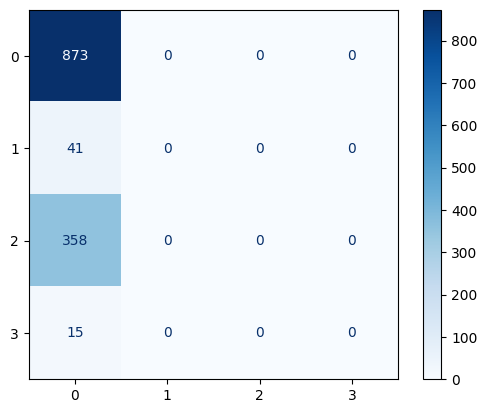

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

class ArabicSentimentClassifier:
    def __init__(self, max_len=100, embedding_dim=300):
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.model = None
        self.embedding_matrix = None

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['Type'] = pd.to_numeric(df['Type'], errors='coerce')
        df.dropna(subset=['Type'], inplace=True)
        self.texts = df['Comment'].astype(str).values
        self.labels = df['Type'].values
        return self.texts, self.labels

    def preprocess(self):
        # Tokenize and pad
        self.tokenizer.fit_on_texts(self.texts)
        sequences = self.tokenizer.texts_to_sequences(self.texts)
        self.word_index = self.tokenizer.word_index
        padded = pad_sequences(sequences, maxlen=self.max_len)
        return padded

    def load_fasttext(self, fasttext_path):
        print("Loading FastText embeddings...")
        embeddings_index = {}
        with open(fasttext_path, encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        num_words = len(self.word_index) + 1
        self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector

        return num_words

    def build_model(self, num_words, trainable=True):
        input_layer = Input(shape=(self.max_len,))
        embedding_layer = Embedding(
            input_dim=num_words,
            output_dim=self.embedding_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_len,
            trainable=trainable
        )(input_layer)

        x = Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3))(embedding_layer)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)  # Changed here

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Changed here
        print(self.model.summary())


    def train(self, X, y, val_split=0.1, batch_size=128, epochs=15):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        )
        class_weights_dict = dict(enumerate(class_weights))

        history = self.model.fit(
            X, y,
            validation_split=val_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stop],
            class_weight=class_weights_dict
        )

        self.plot_history(history)

    def cross_validate(self, X, y, folds=5, batch_size=128, epochs=10):
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=20)
        reports = []

        fold_no = 1
        for train_idx, val_idx in skf.split(X, y):
            print(f"\nFold {fold_no}/{folds}")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Rebuild model for each fold
            self.build_model(num_words=len(self.word_index) + 1, trainable=True)

            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(enumerate(class_weights))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=class_weights_dict,
                verbose=0
            )

            # Predict and report
            y_pred_probs = self.model.predict(X_val) # get predicted probabilities
            y_pred = np.argmax(y_pred_probs, axis=1) # convert probabilities to class labels
            report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
            reports.append(report)

            print(classification_report(y_val, y_pred, zero_division=0))
            fold_no += 1

        return reports


classifier = ArabicSentimentClassifier(max_len=100, embedding_dim=300)
texts, labels = classifier.load_data('Y_cleaned_dataset.csv')
X = classifier.preprocess()
y = np.array(labels)
num_words = classifier.load_fasttext('/content/cc.ar.300.vec')
reports = classifier.cross_validate(X, y, folds=3, batch_size=128, epochs=15)
f1_scores = [r['1.0']['f1-score'] if '1.0' in r else 0 for r in reports]
y_pred = classifier.model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(f"\nMaximum F1-score (toxic): {np.max(f1_scores):.4f}")
print(f"\nMaximum Accuracy (toxic): {np.max(f1_scores):.4f}")
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [13]:
class ArabicSentimentClassifier:
    def __init__(self, max_len=100, embedding_dim=300):
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.model = None
        self.embedding_matrix = None

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['target'] = pd.to_numeric(df['target'], errors='coerce')
        df.dropna(subset=['target'], inplace=True)
        self.texts = df['Comment'].astype(str).values
        self.labels = df['target'].values
        return self.texts, self.labels

    def preprocess(self):
        # Tokenize and pad
        self.tokenizer.fit_on_texts(self.texts)
        sequences = self.tokenizer.texts_to_sequences(self.texts)
        self.word_index = self.tokenizer.word_index
        padded = pad_sequences(sequences, maxlen=self.max_len)
        return padded

    def load_fasttext(self, fasttext_path):
        print("Loading FastText embeddings...")
        embeddings_index = {}
        with open(fasttext_path, encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        num_words = len(self.word_index) + 1
        self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector

        return num_words

    def build_model(self, num_words, trainable=True):
        input_layer = Input(shape=(self.max_len,))
        embedding_layer = Embedding(
            input_dim=num_words,
            output_dim=self.embedding_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_len,
            trainable=trainable
        )(input_layer)

        x = Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3))(embedding_layer)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(self.model.summary())


    def train(self, X, y, val_split=0.1, batch_size=128, epochs=15):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        )
        class_weights_dict = dict(enumerate(class_weights))

        history = self.model.fit(
            X, y,
            validation_split=val_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stop],
            class_weight=class_weights_dict
        )

        self.plot_history(history)

    def cross_validate(self, X, y, folds=3, batch_size=128, epochs=10):
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        reports = []

        fold_no = 1
        for train_idx, val_idx in skf.split(X, y):
            print(f"\nFold {fold_no}/{folds}")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Rebuild model for each fold
            self.build_model(num_words=len(self.word_index) + 1, trainable=True)

            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

            class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weights_dict = dict(enumerate(class_weights))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=class_weights_dict,
                verbose=0
            )

            # Predict and report
            y_pred_probs = self.model.predict(X_val) # get predicted probabilities
            y_pred = np.argmax(y_pred_probs, axis=1) # convert probabilities to class labels
            report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
            reports.append(report)

            print(classification_report(y_val, y_pred, zero_division=0))
            fold_no += 1

        return reports


classifier = ArabicSentimentClassifier(max_len=100, embedding_dim=300)
texts, labels = classifier.load_data('Y_cleaned_dataset.csv')
X = classifier.preprocess()
y = np.array(labels)
num_words = classifier.load_fasttext('/content/cc.ar.300.vec')
reports = classifier.cross_validate(X, y, folds=3, batch_size=128, epochs=15)
f1_scores = [r['1.0']['f1-score'] if '1.0' in r else 0 for r in reports]
y_pred = classifier.model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

print(f"\nMaximum F1-score (toxic): {np.max(f1_scores):.4f}")
print(f"\nMaximum Accuracy (toxic): {np.max(accuracy_score):.4f}")
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Loading FastText embeddings...

Fold 1/3


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_21 (Embedding)        │ (None, 100, 300)       │       223,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,267 (2.53 MB)

 Trainable params: 663,267 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00      16.0
         4.0       0.00      0.00      0.00      15.0

    accuracy                           0.00      31.0
   macro avg       0.00      0.00      0.00      31.0
weighted avg       0.00      0.00      0.00      31.0


Fold 2/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_22 (Embedding)        │ (None, 100, 300)       │       223,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,267 (2.53 MB)

 Trainable params: 663,267 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00      15.0
         3.0       0.00      0.00      0.00       1.0
         4.0       0.00      0.00      0.00      15.0

    accuracy                           0.00      31.0
   macro avg       0.00      0.00      0.00      31.0
weighted avg       0.00      0.00      0.00      31.0


Fold 3/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_23 (Embedding)        │ (None, 100, 300)       │       223,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,267 (2.53 MB)

 Trainable params: 663,267 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00      15.0
         3.0       0.00      0.00      0.00       1.0
         4.0       0.00      0.00      0.00      15.0

    accuracy                           0.00      31.0
   macro avg       0.00      0.00      0.00      31.0
weighted avg       0.00      0.00      0.00      31.0



41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step

Maximum F1-score (toxic): 0.0000


TypeError: unsupported format string passed to function.__format__